# Systems of Ordinary Differential Equations

## Introduction: From Single to Multiple Equations

In the previous notebook, we learned to solve single ODEs like Newton's Law of Cooling:
$$\frac{dT}{dt} = -r(T - T_s)$$

This involved one dependent variable ($T$) changing with time. But many physics problems involve *multiple quantities* that change simultaneously and *influence each other*. These are called **systems of coupled ODEs**.

### Examples of Coupled Systems in Physics

- **Predator-prey dynamics**: Rabbit population affects fox population, and vice versa
- **Coupled oscillators**: Two masses connected by springs
- **Projectile motion with drag**: Horizontal and vertical positions both changing
- **Chemical reactions**: Multiple species with concentrations affecting each other
- **Planetary motion**: Position and velocity both evolving (Newton's laws)
- **RLC circuits**: Current and charge evolving together

**The key feature**: The rate of change of one variable depends on the values of other variables.

---

## Connection to Previous Material

Remember how we handled second-order ODEs? We mentioned they could be rewritten as systems of first-order equations:

$$\frac{d^2y}{dt^2} = f\left(t, y, \frac{dy}{dx}\right)$$

becomes:
$$\frac{dy}{dt} = v, \quad \frac{dv}{dt} = f(t, y, v)$$

This is a **system of two coupled first-order ODEs**. Once we learn to solve systems, we can handle any order.

## System Notation

A system of $n$ coupled first-order ODEs:

$$\frac{dy_1}{dt} = f_1(t, y_1, y_2, \ldots, y_n)$$
$$\frac{dy_2}{dt} = f_2(t, y_1, y_2, \ldots, y_n)$$
$$\vdots$$
$$\frac{dy_n}{dt} = f_n(t, y_1, y_2, \ldots, y_n)$$

**Vector notation** (more compact):
$$\frac{d\vec{y}}{dt} = \vec{f}(t, \vec{y})$$

where $\vec{y} = [y_1, y_2, \ldots, y_n]$ is a vector of all dependent variables.

In Python, we cab represent $\vec{y}$ as a `NumPy` array.

# Example: The Lotka-Volterra Predator-Prey Model
Let's  first look at a system of coupled differential equations to understand how to input equation systems into our differential equation solver.

## The Biology

Imagine an island with rabbits (prey) and foxes (predators):
- **Rabbits** reproduce when food (grass) is plentiful
- **Foxes** eat rabbits to survive and reproduce
- **No rabbits** → Foxes starve
- **No foxes** → Rabbits multiply unchecked

What happens to the populations over time?

## The Mathematics

Let:
- $R(t)$ = rabbit population at time $t$
- $F(t)$ = fox population at time $t$

The **Lotka-Volterra equations** (1920s):

$$\frac{dR}{dt} = \alpha R - \beta RF$$
$$\frac{dF}{dt} = \delta RF - \gamma F$$

**Parameters**:
- $\alpha$ = rabbit birth rate (rabbits reproduce naturally)
- $\beta$ = predation rate (how often foxes catch rabbits)
- $\gamma$ = fox death rate (foxes die without food)
- $\delta$ = fox reproduction efficiency (from eating rabbits)

**Physical interpretation**:
- $\alpha R$: Rabbits grow exponentially when alone
- $-\beta RF$: Rabbit losses proportional to encounters with foxes (more rabbits × more foxes = more encounters)
- $\delta RF$: Fox population grows when they eat rabbits
- $-\gamma F$: Foxes die naturally without food

---

## Implementing the Predator-Prey Model

First, let's set up the problem:

In [2]:
import numpy as np
from matplotlib import pyplot

def predator_prey(t, state):
    """
    Lotka-Volterra predator-prey equations
    
    Parameters
    ----------
    t : float
        Time (not explicitly used, but needed for consistency)
    state : array
        [R, F] where R = prey population, F = predator population
        
    Returns
    -------
    array
        [dR/dt, dF/dt]
    """
    R, F = state  # Unpack the state vector
    
    # Parameters
    alpha = 1.0    # Prey birth rate
    beta = 0.1     # Predation rate
    gamma = 1.5    # Predator death rate
    delta = 0.075  # Predator reproduction efficiency
    
    # The coupled ODEs
    dR_dt = alpha*R - beta*R*F
    dF_dt = delta*R*F - gamma*F
    
    return np.array([dR_dt, dF_dt])

# Initial conditions: 40 rabbits, 9 foxes
initial_state = np.array([40.0, 9.0])

## Solving with RK4: Adapting for Systems

The RK4 algorithm works the same way, but now each $k$ value is a **vector**:


## Solving with RK4: Manual Stepping (Educational)

Let's first solve it "by hand" using our RK4 implementation to see how systems work. The RK4 algorithm is the same, but now each $k$ value is a **vector**:


In [3]:
# Import our RK4 function from previous notebook
from diffeq import rk4_step
import matplotlib.pyplot as mp

# Time parameters for manual solution
t_max = 50.0
dt = 0.05
nsteps = int(t_max/dt) + 1

# Storage arrays
time = np.arange(0, t_max + dt, dt)
populations = np.zeros((nsteps, 2))  # 2 columns: rabbits, foxes

# Initial condition
populations[0] = initial_state

# Time evolution using manual RK4 stepping
state = initial_state.copy()
for i in range(1, nsteps):
    t = time[i-1]
    state = rk4_step(state, predator_prey, t, dt)
    populations[i] = state

# Extract individual populations
rabbits = populations[:, 0]
foxes = populations[:, 1]

print(f"Manual RK4 completed {nsteps} steps")
print(f"Final populations: {rabbits[-1]:.1f} rabbits, {foxes[-1]:.1f} foxes")


Manual RK4 completed 1001 steps
Final populations: 25.1 rabbits, 22.2 foxes


**What's different from single ODEs?**
- `state` is now an array: `[R, F]`
- `rk4_step` receives an array and returns an array
- Each $k$ inside RK4 is an array: `[dR/dt, dF/dt]`
- The arithmetic (addition, multiplication) works element-wise on arrays!
- **Nothing else changes** - same weights, same structure

The beauty of vector notation is that RK4 works for systems with NO changes to the algorithm.

---

## Using `scipy.integrate`

Now let's solve the same problem using `solve_ivp` - this is how you'll typically work:

In [4]:
from scipy.integrate import solve_ivp

# Solve using scipy (much cleaner!)
sol = solve_ivp(
    predator_prey,
    [0, 50],              # Time span
    initial_state,        # Initial conditions
    method='RK45',        # Adaptive RK method
    dense_output=True,    # Enable smooth interpolation
    max_step=0.1          # Limit step size for accuracy
)

print(f"solve_ivp used {len(sol.t)} adaptive time steps")
print(f"Compare to our {nsteps} fixed steps")

# Create smooth solution for plotting
t_smooth = np.linspace(0, 50, 1000)
solution = sol.sol(t_smooth)  # Use interpolator
rabbits_scipy = solution[0]
foxes_scipy = solution[1]


solve_ivp used 502 adaptive time steps
Compare to our 1001 fixed steps


## Visualizing Population Dynamics

Let's plot both solutions to compare:

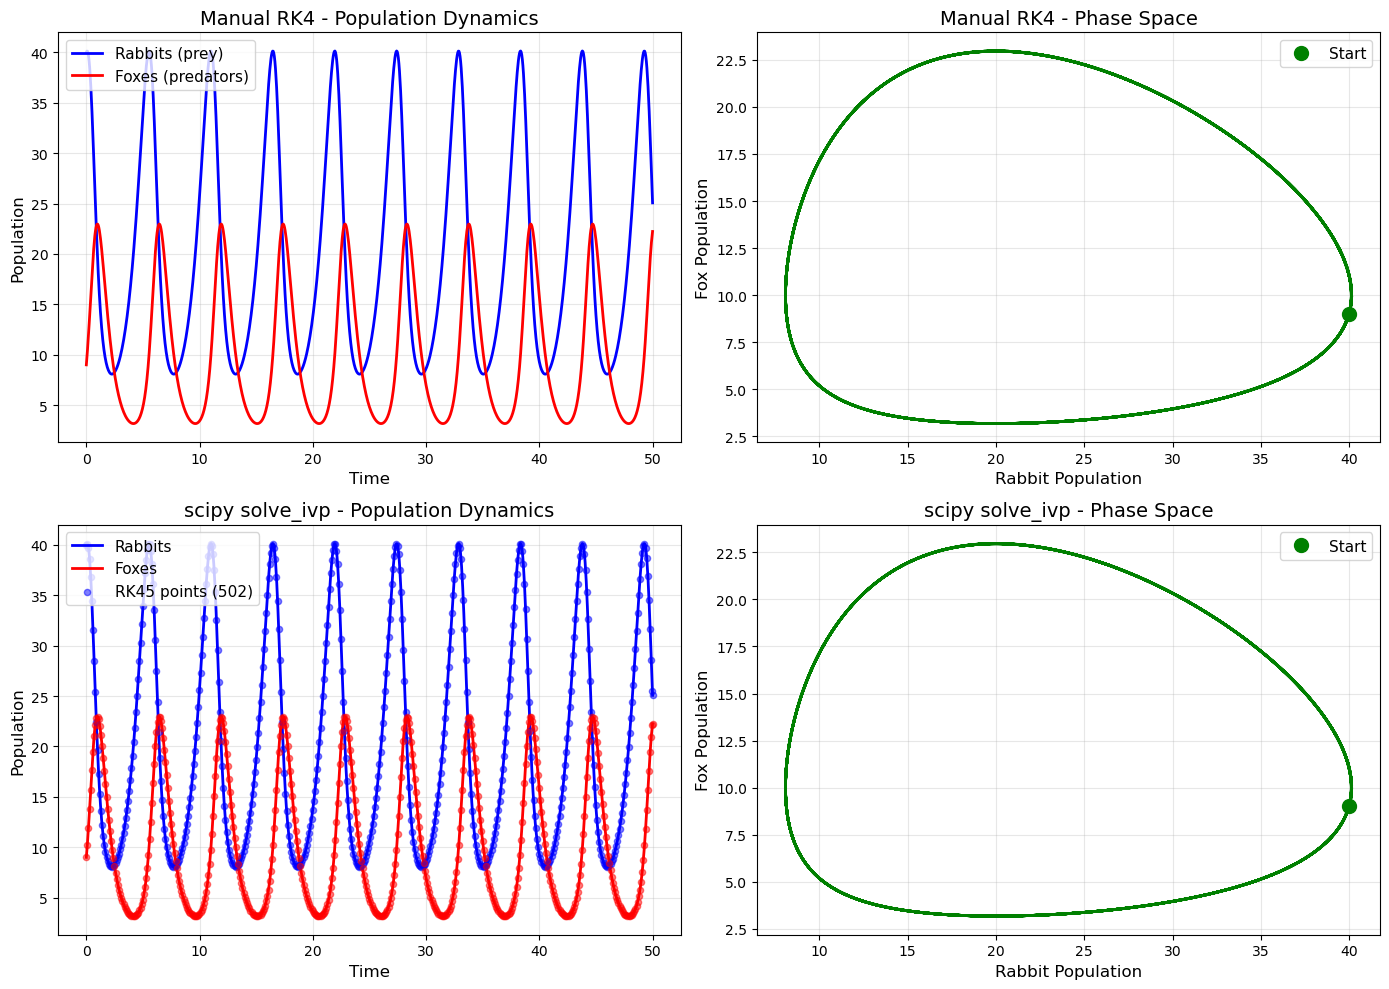

In [5]:
pyplot.figure(figsize=(14, 10))

# Top row: Manual RK4 solution
pyplot.subplot(2, 2, 1)
pyplot.plot(time, rabbits, 'b-', linewidth=2, label='Rabbits (prey)')
pyplot.plot(time, foxes, 'r-', linewidth=2, label='Foxes (predators)')
pyplot.xlabel('Time', fontsize=12)
pyplot.ylabel('Population', fontsize=12)
pyplot.title('Manual RK4 - Population Dynamics', fontsize=14)
pyplot.legend(fontsize=11)
pyplot.grid(True, alpha=0.3)

pyplot.subplot(2, 2, 2)
pyplot.plot(rabbits, foxes, 'g-', linewidth=2)
pyplot.plot(rabbits[0], foxes[0], 'go', markersize=10, label='Start')
pyplot.xlabel('Rabbit Population', fontsize=12)
pyplot.ylabel('Fox Population', fontsize=12)
pyplot.title('Manual RK4 - Phase Space', fontsize=14)
pyplot.legend(fontsize=11)
pyplot.grid(True, alpha=0.3)

# Bottom row: scipy solution
pyplot.subplot(2, 2, 3)
pyplot.plot(t_smooth, rabbits_scipy, 'b-', linewidth=2, label='Rabbits')
pyplot.plot(t_smooth, foxes_scipy, 'r-', linewidth=2, label='Foxes')
pyplot.scatter(sol.t, sol.y[0], s=20, c='blue', alpha=0.5, zorder=3, label=f'RK45 points ({len(sol.t)})')
pyplot.scatter(sol.t, sol.y[1], s=20, c='red', alpha=0.5, zorder=3)
pyplot.xlabel('Time', fontsize=12)
pyplot.ylabel('Population', fontsize=12)
pyplot.title('scipy solve_ivp - Population Dynamics', fontsize=14)
pyplot.legend(fontsize=11)
pyplot.grid(True, alpha=0.3)

pyplot.subplot(2, 2, 4)
pyplot.plot(rabbits_scipy, foxes_scipy, 'g-', linewidth=2)
pyplot.plot(rabbits_scipy[0], foxes_scipy[0], 'go', markersize=10, label='Start')
pyplot.xlabel('Rabbit Population', fontsize=12)
pyplot.ylabel('Fox Population', fontsize=12)
pyplot.title('scipy solve_ivp - Phase Space', fontsize=14)
pyplot.legend(fontsize=11)
pyplot.grid(True, alpha=0.3)

pyplot.tight_layout()
pyplot.show()

**What do you observe?**

1. **Time series**: Populations oscillate! The oscillations are out of phase:
   - Rabbits increase → More food for foxes → Foxes increase (with delay)
   - Foxes increase → More predation → Rabbits decrease
   - Rabbits decrease → Foxes starve → Foxes decrease
   - Foxes decrease → Less predation → Rabbits recover
   - **The cycle repeats**

2. **Phase space**: The trajectory forms a closed loop called a **limit cycle**
   - The system returns to the same state repeatedly
   - This is a stable, periodic oscillation
   - The ecosystem is self-regulating!

# Converting Higher-Order ODEs to Systems

## The General Procedure

Any $n$-th order ODE can be converted to a system of $n$ first-order ODEs.

### Second-Order ODE → System of 2 Equations

**General form**:
$$\frac{d^2y}{dt^2} = g\left(t, y, \frac{dy}{dt}\right)$$

**Introduce a new variable** for the first derivative:
$$v = \frac{dy}{dt}$$

**Then we have two first-order equations**:
$$\frac{dy}{dt} = v$$
$$\frac{dv}{dt} = g(t, y, v)$$

This is now a system we can solve!

### Third-Order ODE → System of 3 Equations

$$\frac{d^3y}{dt^3} = h\left(t, y, \frac{dy}{dt}, \frac{d^2y}{dt^2}\right)$$

**Introduce variables**:
$$v_1 = \frac{dy}{dt}, \quad v_2 = \frac{d^2y}{dt^2}$$

**System**:
$$\frac{dy}{dt} = v_1$$
$$\frac{dv_1}{dt} = v_2$$
$$\frac{dv_2}{dt} = h(t, y, v_1, v_2)$$

### General n-th Order

The pattern continues: introduce $n-1$ new variables for the derivatives, get $n$ first-order equations!

**Bottom line**: Every ODE, no matter how high the order, can be solved using the same RK4 system solver.

---


# Example: Projectile Motion with Air Resistance

## The Physics

A projectile launched at angle $\theta$ with initial speed $v_0$:
- **Without drag**: Simple parabolic trajectory (you've solved this analytically)
- **With drag**: No analytical solution! Must solve numerically.

### Forces Acting

**Gravity**: $\vec{F}_g = -mg\hat{j}$

**Air resistance** (drag): $\vec{F}_d = -b\vec{v}$ (proportional to velocity)
- Opposes motion in both x and y directions
- Magnitude depends on speed: $F_d = b|\vec{v}|$ where $b$ is the drag coefficient

### Newton's Second Law

$$m\frac{d\vec{v}}{dt} = \vec{F}_g + \vec{F}_d$$

In components:
$$m\frac{dv_x}{dt} = -bv_x$$
$$m\frac{dv_y}{dt} = -mg - bv_y$$

We also need equations for position:
$$\frac{dx}{dt} = v_x$$
$$\frac{dy}{dt} = v_y$$

*This is a system of 4 coupled first-order ODEs!*

In [6]:
def projectile_with_drag(t, state):
    """
    Projectile motion with linear air resistance
    
    state = [x, y, vx, vy]
    Returns [dx/dt, dy/dt, dvx/dt, dvy/dt]
    """
    x, y, vx, vy = state
    
    # Parameters
    g = 9.8      # Gravity (m/s²)
    b = 0.1      # Drag coefficient (kg/s)
    m = 0.5      # Mass (kg)
    
    # Equations of motion
    dx_dt = vx
    dy_dt = vy
    dvx_dt = -(b/m) * vx
    dvy_dt = -g - (b/m) * vy
    
    return np.array([dx_dt, dy_dt, dvx_dt, dvy_dt])
# Initial conditions
v0 = 30.0        # Initial speed (m/s)
angle = 45.0     # Launch angle (degrees)
theta = np.radians(angle)

# Convert to components
x0 = 0.0
y0 = 0.0
vx0 = v0 * np.cos(theta)
vy0 = v0 * np.sin(theta)

initial_state_proj = np.array([x0, y0, vx0, vy0])

## Solving the system

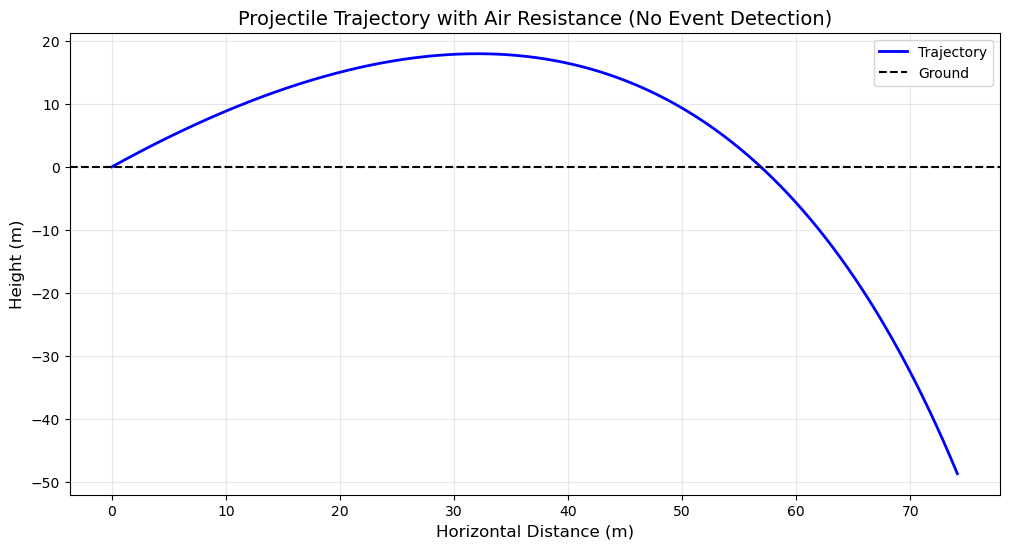

Projectile went underground at index 320
Final height: y = -48.67 m

Problem: We simulated past when it hit the ground!


In [7]:
from scipy.integrate import solve_ivp

# Solve for a generous time span
sol_no_event = solve_ivp(
    projectile_with_drag,
    [0, 6],               # Time span: 0 to 6 seconds
    initial_state_proj,
    method='RK45',
    dense_output=True,
    max_step=0.01
)

# Create smooth trajectory for plotting
t_plot = np.linspace(0, sol_no_event.t[-1], 500)
trajectory = sol_no_event.sol(t_plot)

x_vals = trajectory[0]
y_vals = trajectory[1]

# Plot trajectory
pyplot.figure(figsize=(12, 6))
pyplot.plot(x_vals, y_vals, 'b-', linewidth=2, label='Trajectory')
pyplot.axhline(y=0, color='k', linestyle='--', linewidth=1.5, label='Ground')
pyplot.xlabel('Horizontal Distance (m)', fontsize=12)
pyplot.ylabel('Height (m)', fontsize=12)
pyplot.title('Projectile Trajectory with Air Resistance (No Event Detection)', fontsize=14)
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.show()

# Find where it crosses y=0
ground_crossing_idx = np.where(y_vals < 0)[0]
if len(ground_crossing_idx) > 0:
    first_underground = ground_crossing_idx[0]
    print(f"Projectile went underground at index {first_underground}")
    print(f"Final height: y = {y_vals[-1]:.2f} m")
    print("\nProblem: We simulated past when it hit the ground!")

### Problem
The projectile goes underground! We need to *stop the integration* when y reaches 0.

This is where scipy's **event detection** comes out to play.

# Event Detection with scipy.integrate.solve_ivp

## What Are Events?

**Events** are conditions we want to monitor during integration:
- Projectile hits ground (y = 0)
- Two objects collide (distance = 0)
- Temperature reaches threshold
- Orbit reaches aphelion (r is maximum)
- Chemical reaction reaches equilibrium

scipy can **detect** when these occur and **stop** integration automatically!

---

## Defining an Event Function

An event function returns **zero** when the event occurs:


In [8]:
def hit_max(t, state):
    """
    Event function: returns 0 when event occurs
    
    Parameters
    ----------
    t : float
        Current time
    state : array
        [x, y, vx, vy]
        
    Returns
    -------
    float
        coordinate indicating event
    """
    x, y, vx, vy = state
    return vy  # or state[3] 

**How it works**: scipy monitors the sign of this function. When it changes from positive to negative, `the event` has occurred

We can also specify that this event should *terminate* the integration:


In [9]:
hit_max.terminal = True  # Stop integration when event occurs
hit_max.direction = -1   # What? Why +/-1?

## Solving Projectile Motion with Event Detection

Now let's do it properly with event detection:

✓ Event detected: Projectile reaches maximum height
Zenith time: 1.799 seconds
Max h position: x = 32.05 m, y = 17.935578 m
Max h velocity: vx = 14.80 m/s, vy = 0.00 m/s
Max h speed: 14.80 m/s
Range: 32.05 m


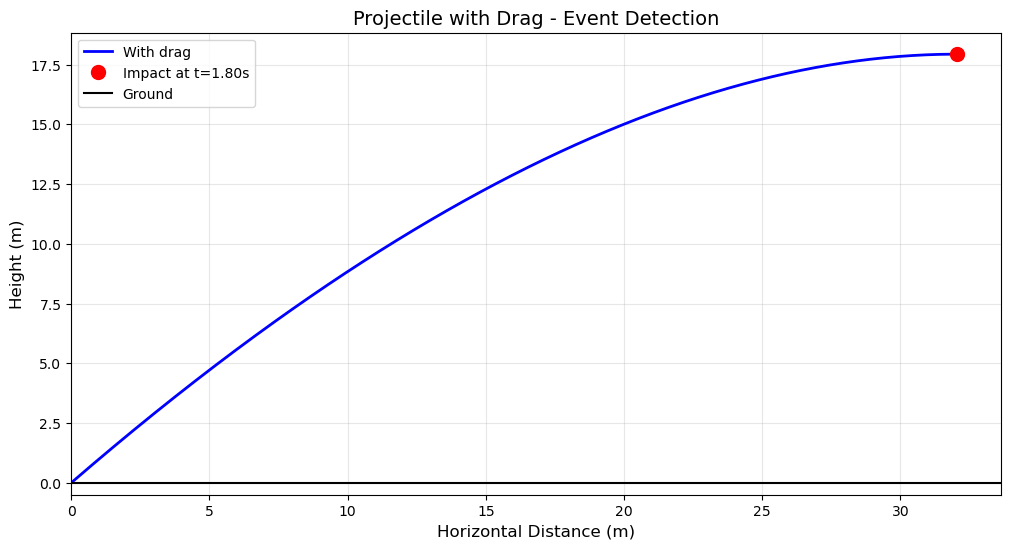

In [12]:
def hit_max(t, state):
    """
    Event function: returns 0 when projectile hits maximum
    
    Parameters
    ----------
    t : float
        Current time
    state : array
        [x, y, vx, vy]
        
    Returns
    -------
    float
        velocity in the y-direction
    """
    return state[3]  # y velocity

# Configure the event
hit_max.terminal = True   # Stop integration when event occurs
hit_max.direction = -1    # Only detect when y goes from + to - (falling)

# Solve with event detection
sol = solve_ivp(
    projectile_with_drag,
    [0, 10],                # Generous time span
    initial_state_proj,
    method='RK45',
    events=hit_max,      # Our event function!
    dense_output=True,
    max_step=0.01
)

# Check results
if sol.status == 1:  # 1 means terminated by event
    print("✓ Event detected: Projectile reaches maximum height")
    maxh_time = sol.t_events[0][0]
    print(f"Zenith time: {maxh_time:.3f} seconds")
    
    # Get state at event
    maxh_state = sol.y_events[0][0]
    x_maxh, y_maxh, vx_maxh, vy_maxh = maxh_state
    print(f"Max h position: x = {x_maxh:.2f} m, y = {y_maxh:.6f} m")
    print(f"Max h velocity: vx = {vx_maxh:.2f} m/s, vy = {vy_maxh:.2f} m/s")
    print(f"Max h speed: {np.sqrt(vx_maxh**2 + vy_maxh**2):.2f} m/s")
    print(f"Range: {x_maxh:.2f} m")

# Plot the trajectory
t_plot = np.linspace(0, sol.t[-1], 500)
traj = sol.sol(t_plot)

pyplot.figure(figsize=(12, 6))
pyplot.plot(traj[0], traj[1], 'b-', linewidth=2, label='With drag')
pyplot.plot(x_maxh, y_maxh, 'ro', markersize=10, label=f'Impact at t={maxh_time:.2f}s')
pyplot.axhline(y=0, color='k', linestyle='-', linewidth=1.5, label='Ground')
pyplot.xlabel('Horizontal Distance (m)', fontsize=12)
pyplot.ylabel('Height (m)', fontsize=12)
pyplot.title('Projectile with Drag - Event Detection', fontsize=14)
pyplot.legend()
pyplot.grid(True, alpha=0.3)
pyplot.xlim(0, None)
pyplot.ylim(-0.5, None)
pyplot.show()

In [14]:
sol.t_events

[array([1.79858039])]

The integration automatically stopped right when the projectile hit the ground.

# Generalizing: The Power of Vector Notation

## Why This Approach is Powerful

When we write ODEs in vector form:
$$\frac{d\vec{y}}{dt} = \vec{f}(t, \vec{y})$$

**One function handles everything**:
- Single ODEs: $\vec{y}$ is a 1-element array
- Systems: $\vec{y}$ is a multi-element array
- Any order: Convert to first-order system

**The RK4 algorithm doesn't care**:
```python
def rk4_step_system(y, f, t, dt):
    # Works for ANY size array!
    k1 = f(t, y)
    k2 = f(t + 0.5*dt, y + 0.5*dt*k1)
    k3 = f(t + 0.5*dt, y + 0.5*dt*k2)
    k4 = f(t + dt, y + dt*k3)
    return y + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
```

Whether $y$ has 1, 4, or 100 components, this code works unchanged

---

# Key Takeaways: Systems of ODEs

1. **Systems are everywhere** in physics - coupled equations are the norm, not the exception

2. **Convert high-order to systems** - Any n-th order ODE becomes n first-order equations

3. **RK4 works for systems** - Same algorithm, just use arrays instead of scalars

4. **Vector notation simplifies** - Write once, works for any system size

5. **Event detection is powerful** - Stop integration when physical conditions are met

6. **scipy.integrate is essential** - Use `solve_ivp` with events for production code

# Project 2: Drag Forces

Using this notebook as a reference to complete Project 2. That assignment uses the quadratic drag force, $F(v) = -cv^2$ as opposed to the linear drag force from the above code. Please refer to the assignment for more details. 